# Utils

In [1]:
!pip install einops
!pip install wandb
import torch
import einops
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import torchvision
import torchvision.transforms as transforms
import wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [2]:
import urllib.request
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import read_image

torch.manual_seed(1)

import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Dataset

In [3]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')


In [4]:
!kaggle datasets download -d praneshmukhopadhyay/youtubers-saying-things

! unzip "youtubers-saying-things.zip"


Dataset URL: https://www.kaggle.com/datasets/praneshmukhopadhyay/youtubers-saying-things
License(s): CC0-1.0
 82% 9.00M/11.0M [00:01<00:00, 9.79MB/s]
100% 11.0M/11.0M [00:01<00:00, 7.20MB/s]
Archive:  youtubers-saying-things.zip
  inflating: data.csv                


In [5]:
!rm -rf images
!mkdir images

In [6]:
from tqdm import tqdm
import csv
sample = None
from urllib.error import HTTPError


def path_to_img(path):
    img = read_image(path)
    plot([img])

def row_to_img(row, path):
    imgURL = f"https://i.ytimg.com/vi/{row[0]}/hqdefault.jpg"
    # print(imgURL)
    urllib.request.urlretrieve(imgURL, path)
    img = read_image(path)
    # transform = torchvision.transforms.CenterCrop(size=(224, 224))
    # out = transform(img)
    # return out
    return img
import sys
csv.field_size_limit(sys.maxsize)

def load_images():
  with open('data.csv', newline='') as f:
      reader = csv.reader(f)
      index = 0
      ids = []
      for row in tqdm(reader):
          index+=1
          if (index==1):
            continue
          sample =row
          dct = {}
          path = f"./images/{index}.jpg"
          try:
            row_to_img(row, path)
            dct['image'], dct['title'] = path, row[3]
            ids.append(dct)
          except HTTPError:
            print(f"No Id for {index}")
            index-=1

          if (index>2500):
            break
  return ids

In [7]:
ids = load_images()

334it [00:08, 42.97it/s]

No Id for 331


1949it [00:44, 43.88it/s]

No Id for 1936


KeyboardInterrupt: 

In [ ]:
idx = -1
path_to_img(ids[idx]['image'])
ids[idx]['title']

In [ ]:
titles = [section['title'] for section in ids]
paths = [section['image'] for section in ids]


In [8]:
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
class CLIPDataset(torch.utils.data.Dataset):
  def __init__(self, titles, paths, tokenizer=tokenizer, transform=torchvision.transforms.CenterCrop(size=(80, 80))):
    super().__init__()
    self.titles = titles
    self.paths = paths
    assert len(self.titles) == len(self.paths), "Mis-matched lengths"

    self.tokenizer = tokenizer
    self.transform = transform

    # self.captions = list(captions)
    self.encoded_captions = tokenizer(
        list(titles), padding=True, truncation=True, max_length=100
    )

  def __len__(self):
    return len(self.titles)

  # def __getitem__(self, idx):
  #   title, path = self.titles[idx], self.paths[idx]
  #   img = self.transform(read_image(path))
  #   tokens = self.tokenizer(
  #           list(title), padding=True, truncation=True, max_length=30
  #   )

  #   # return img, 0
  #   return img, [tokens]
  def __getitem__(self, idx):
    title, path = self.titles[idx], self.paths[idx]
    img = self.transform(read_image(path))

    item = {
        key: torch.tensor(values[idx])
        for key, values in self.encoded_captions.items()
    }

    item['image']=img





    return item




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# dataset = CLIPDataset(titles,paths)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# iteration = iter(dataloader)
# ne = next(iteration)


In [ ]:
ne = None
for batch in iteration:
  ne = batch
  break



# Architectures


In [9]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self,input):
        x = self.norm(input)
        qkv = self.to_qkv(x).chunk(3,dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)

class FeedForward(nn.Module):
  def __init__(self,dim, hidden_dim):
    super().__init__()
    self.network = nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, dim)
    )
  def forward(self, input):
    return self.network(input)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads, dim_head),
                FeedForward(dim, mlp_dim)
            ]))

    def forward(self, x):
      for (attn, ff) in self.layers:
        x = attn(x) + x
        x = ff(x) + x
      return self.norm(x)



class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)



In [10]:
class TextEncoder(nn.Module):

    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]


In [11]:
class Projection(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=.1):
        super().__init__()
        self.in_to_out = nn.Linear(in_dim, out_features=out_dim)
        self.fc = nn.Sequential(
            nn.GELU(),
            nn.Linear(out_dim, out_dim),
            nn.Dropout(dropout)
        )
        self.layer_norm = nn.LayerNorm(out_dim)

    def forward(self, input):
      input = self.in_to_out(input)
      x = self.fc(input) + input
      return self.layer_norm(x)

In [12]:
from torch.nn.functional import softmax

class CLIP(nn.Module):
  def __init__(self):
    super().__init__()
    self.text_encoder = TextEncoder()
    self.image_encoder = ViT(
      channels=3,
      image_size=80,
      patch_size=8,
      num_classes=256,
      dim=64,
      depth=6,
      heads=8,
      mlp_dim=128,
      dropout=0.1,
      emb_dropout=0.1
    )
    self.temperature = 1.0

    self.text_projection = Projection(768, 200)
    self.vision_projection = Projection(256, 200)


  def forward(self, ids, attn, c):

    text_embedding = self.text_encoder(ids, attn)
    vision_embedding = self.image_encoder(c)
    text_multi = self.text_projection(text_embedding)
    vision_multi = self.vision_projection(vision_embedding)

    logits = (text_multi @ vision_multi.T) / self.temperature

    images_similarity = vision_multi @ vision_multi.T
    texts_similarity = text_multi @ text_multi.T

    targets = softmax(
        (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
    )

    texts_loss = cross_entropy(logits, targets, reduction='none')
    images_loss = cross_entropy(logits.T, targets.T, reduction='none')
    loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
    return loss.mean()

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()


In [13]:
clip_model = CLIP()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [14]:
# testing
# iteration = iter(dataloader)
# next = next(iteration)
# c = next['image'].to(dtype=torch.float32)
# ids = next['input_ids']
# attn = next['attention_mask']
# out = clip_model(ids, attn, c)

In [15]:
# out

In [16]:



!kaggle datasets download -d adityajn105/flickr8k
!unzip "flickr8k.zip"

def create_title_image_list(file_path):
    title_image_list = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            line = line.strip()
            split_up = line.split(',')
            if len(split_up)==2:
                image_path, title = split_up[0], split_up[1]
                title_image_list.append((title, f"./Images/{image_path}"))

    return title_image_list
data = create_title_image_list("captions.txt")
titles = [datum[0] for datum in data]
image_paths = [datum[1] for datum in data]
image_paths.pop(0)
titles.pop(0)


Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

NameError: name 'DataLoader' is not defined

In [17]:
import torch
import wandb
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from tqdm import tqdm

flickr_dataset = CLIPDataset(titles, image_paths)
flickr_dataloader = DataLoader(flickr_dataset, batch_size=32, shuffle=True)


# Training

In [18]:
import torch
import wandb
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from tqdm import tqdm

wandb.init(project="CLIP")
wandb.config.dataset = "FlickR"

clip_model = CLIP()

optimizer = torch.optim.Adam(clip_model.parameters(), lr=1e-4)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = flickr_dataloader

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [19]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    clip_model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()

        # Extract data from batch
        c = batch['image'].to(dtype=torch.float32)
        ids = batch['input_ids']
        attn = batch['attention_mask']

        # Forward pass
        loss = clip_model(ids, attn, c)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        wandb.log({"Loss": loss.item()})
        print(loss.item())

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(dataloader)

    # Log the loss to wandb
    # wandb.log({" Loss": avg_loss})


Epoch 1/1:   0%|          | 1/1188 [00:01<30:03,  1.52s/it]

14.15172290802002


Epoch 1/1:   0%|          | 2/1188 [00:02<26:41,  1.35s/it]

8.592663764953613


Epoch 1/1:   0%|          | 3/1188 [00:03<25:08,  1.27s/it]

7.075441360473633


Epoch 1/1:   0%|          | 4/1188 [00:04<22:47,  1.16s/it]

8.234642028808594


Epoch 1/1:   0%|          | 5/1188 [00:05<20:17,  1.03s/it]

6.7638936042785645


Epoch 1/1:   1%|          | 6/1188 [00:06<18:32,  1.06it/s]

6.554296016693115


Epoch 1/1:   1%|          | 7/1188 [00:07<17:24,  1.13it/s]

5.978809833526611


Epoch 1/1:   1%|          | 8/1188 [00:08<16:46,  1.17it/s]

6.941947937011719


Epoch 1/1:   1%|          | 9/1188 [00:08<16:17,  1.21it/s]

7.638950824737549


Epoch 1/1:   1%|          | 10/1188 [00:09<16:23,  1.20it/s]

5.78501033782959


Epoch 1/1:   1%|          | 11/1188 [00:10<16:53,  1.16it/s]

6.427818298339844


Epoch 1/1:   1%|          | 12/1188 [00:11<17:20,  1.13it/s]

5.682463645935059


Epoch 1/1:   1%|          | 13/1188 [00:12<19:00,  1.03it/s]

5.89088249206543


Epoch 1/1:   1%|          | 14/1188 [00:13<20:13,  1.03s/it]

6.278946399688721


Epoch 1/1:   1%|▏         | 15/1188 [00:15<20:57,  1.07s/it]

6.0138468742370605


Epoch 1/1:   1%|▏         | 16/1188 [00:15<19:30,  1.00it/s]

5.320374011993408


Epoch 1/1:   1%|▏         | 17/1188 [00:16<18:01,  1.08it/s]

5.768248558044434


Epoch 1/1:   2%|▏         | 18/1188 [00:17<16:59,  1.15it/s]

5.626995086669922


Epoch 1/1:   2%|▏         | 19/1188 [00:18<16:19,  1.19it/s]

5.586958885192871


Epoch 1/1:   2%|▏         | 20/1188 [00:18<15:53,  1.22it/s]

5.401957988739014


Epoch 1/1:   2%|▏         | 21/1188 [00:19<15:34,  1.25it/s]

4.709156036376953


Epoch 1/1:   2%|▏         | 22/1188 [00:20<15:19,  1.27it/s]

5.396722316741943


Epoch 1/1:   2%|▏         | 23/1188 [00:21<15:08,  1.28it/s]

5.060458183288574


Epoch 1/1:   2%|▏         | 24/1188 [00:21<14:59,  1.29it/s]

5.183431625366211


Epoch 1/1:   2%|▏         | 25/1188 [00:22<14:55,  1.30it/s]

5.222698211669922


Epoch 1/1:   2%|▏         | 26/1188 [00:23<14:52,  1.30it/s]

4.748648166656494


Epoch 1/1:   2%|▏         | 27/1188 [00:24<14:58,  1.29it/s]

4.918765544891357


Epoch 1/1:   2%|▏         | 28/1188 [00:25<14:57,  1.29it/s]

5.226055145263672


Epoch 1/1:   2%|▏         | 29/1188 [00:25<15:45,  1.23it/s]

4.780416011810303


Epoch 1/1:   3%|▎         | 30/1188 [00:26<16:42,  1.15it/s]

4.572772979736328


Epoch 1/1:   3%|▎         | 31/1188 [00:28<18:42,  1.03it/s]

4.3651604652404785


Epoch 1/1:   3%|▎         | 32/1188 [00:29<20:26,  1.06s/it]

4.386139869689941


Epoch 1/1:   3%|▎         | 33/1188 [00:30<21:50,  1.13s/it]

4.450840950012207


Epoch 1/1:   3%|▎         | 34/1188 [00:31<22:19,  1.16s/it]

4.375446796417236


Epoch 1/1:   3%|▎         | 35/1188 [00:32<20:28,  1.07s/it]

4.4431071281433105


Epoch 1/1:   3%|▎         | 36/1188 [00:33<18:43,  1.03it/s]

4.352668285369873


Epoch 1/1:   3%|▎         | 37/1188 [00:34<17:31,  1.09it/s]

4.678193092346191


Epoch 1/1:   3%|▎         | 38/1188 [00:35<16:33,  1.16it/s]

4.466831207275391


Epoch 1/1:   3%|▎         | 39/1188 [00:35<16:03,  1.19it/s]

4.158519744873047


Epoch 1/1:   3%|▎         | 40/1188 [00:36<15:43,  1.22it/s]

4.287501811981201


Epoch 1/1:   3%|▎         | 41/1188 [00:37<15:16,  1.25it/s]

4.899750709533691


Epoch 1/1:   4%|▎         | 42/1188 [00:38<15:03,  1.27it/s]

4.491265296936035


Epoch 1/1:   4%|▎         | 43/1188 [00:38<14:53,  1.28it/s]

4.217206001281738


Epoch 1/1:   4%|▎         | 44/1188 [00:39<14:50,  1.28it/s]

4.286674499511719


Epoch 1/1:   4%|▍         | 45/1188 [00:40<14:41,  1.30it/s]

4.167663097381592


Epoch 1/1:   4%|▍         | 46/1188 [00:41<14:37,  1.30it/s]

4.086330413818359


Epoch 1/1:   4%|▍         | 47/1188 [00:42<14:59,  1.27it/s]

4.34482479095459


Epoch 1/1:   4%|▍         | 48/1188 [00:43<17:11,  1.11it/s]

4.236603260040283


Epoch 1/1:   4%|▍         | 49/1188 [00:44<18:43,  1.01it/s]

4.392307281494141


Epoch 1/1:   4%|▍         | 50/1188 [00:45<19:54,  1.05s/it]

4.818636894226074


Epoch 1/1:   4%|▍         | 51/1188 [00:46<20:47,  1.10s/it]

4.098119735717773


Epoch 1/1:   4%|▍         | 52/1188 [00:47<19:17,  1.02s/it]

4.213626384735107


Epoch 1/1:   4%|▍         | 53/1188 [00:48<17:48,  1.06it/s]

4.192771911621094


Epoch 1/1:   5%|▍         | 54/1188 [00:49<16:50,  1.12it/s]

4.107027530670166


Epoch 1/1:   5%|▍         | 55/1188 [00:49<16:05,  1.17it/s]

4.0719828605651855


Epoch 1/1:   5%|▍         | 56/1188 [00:50<15:32,  1.21it/s]

4.32439661026001


Epoch 1/1:   5%|▍         | 57/1188 [00:51<15:10,  1.24it/s]

4.231678485870361


Epoch 1/1:   5%|▍         | 58/1188 [00:52<15:06,  1.25it/s]

4.100907802581787


Epoch 1/1:   5%|▍         | 59/1188 [00:52<14:48,  1.27it/s]

3.937687873840332


Epoch 1/1:   5%|▌         | 60/1188 [00:53<14:36,  1.29it/s]

4.150585174560547


Epoch 1/1:   5%|▌         | 61/1188 [00:54<14:43,  1.28it/s]

4.0083770751953125


Epoch 1/1:   5%|▌         | 62/1188 [00:55<14:35,  1.29it/s]

4.156974792480469


Epoch 1/1:   5%|▌         | 63/1188 [00:56<14:36,  1.28it/s]

4.13377046585083


Epoch 1/1:   5%|▌         | 64/1188 [00:56<14:35,  1.28it/s]

4.100633144378662


Epoch 1/1:   5%|▌         | 65/1188 [00:58<16:51,  1.11it/s]

3.9697158336639404


Epoch 1/1:   6%|▌         | 66/1188 [00:59<17:57,  1.04it/s]

4.172361850738525


Epoch 1/1:   6%|▌         | 67/1188 [01:00<19:10,  1.03s/it]

4.065506458282471


Epoch 1/1:   6%|▌         | 68/1188 [01:01<19:57,  1.07s/it]

4.2181267738342285


Epoch 1/1:   6%|▌         | 69/1188 [01:02<19:40,  1.06s/it]

4.095376491546631


Epoch 1/1:   6%|▌         | 70/1188 [01:03<17:55,  1.04it/s]

4.084994316101074


Epoch 1/1:   6%|▌         | 71/1188 [01:03<16:44,  1.11it/s]

4.101966381072998


Epoch 1/1:   6%|▌         | 72/1188 [01:04<16:04,  1.16it/s]

4.092187404632568


Epoch 1/1:   6%|▌         | 73/1188 [01:05<16:15,  1.14it/s]

3.996055841445923


Epoch 1/1:   6%|▌         | 74/1188 [01:06<15:33,  1.19it/s]

3.9144389629364014


Epoch 1/1:   6%|▋         | 75/1188 [01:07<15:04,  1.23it/s]

4.054765701293945


Epoch 1/1:   6%|▋         | 76/1188 [01:07<14:46,  1.25it/s]

4.074936866760254


Epoch 1/1:   6%|▋         | 77/1188 [01:08<14:38,  1.26it/s]

3.7974486351013184


Epoch 1/1:   7%|▋         | 78/1188 [01:09<14:34,  1.27it/s]

3.926901340484619


Epoch 1/1:   7%|▋         | 79/1188 [01:10<14:24,  1.28it/s]

3.828721523284912


Epoch 1/1:   7%|▋         | 80/1188 [01:11<15:01,  1.23it/s]

3.880131244659424


Epoch 1/1:   7%|▋         | 81/1188 [01:12<15:37,  1.18it/s]

4.014904499053955


Epoch 1/1:   7%|▋         | 82/1188 [01:13<17:26,  1.06it/s]

3.8889615535736084


Epoch 1/1:   7%|▋         | 83/1188 [01:14<18:49,  1.02s/it]

3.8990941047668457


Epoch 1/1:   7%|▋         | 84/1188 [01:15<19:47,  1.08s/it]

3.831362247467041


Epoch 1/1:   7%|▋         | 85/1188 [01:16<20:40,  1.13s/it]

3.8280646800994873


Epoch 1/1:   7%|▋         | 86/1188 [01:18<20:52,  1.14s/it]

3.761613130569458


Epoch 1/1:   7%|▋         | 87/1188 [01:18<18:56,  1.03s/it]

3.8393232822418213


Epoch 1/1:   7%|▋         | 88/1188 [01:19<17:32,  1.04it/s]

3.8391339778900146


Epoch 1/1:   7%|▋         | 89/1188 [01:20<16:27,  1.11it/s]

3.919279098510742


Epoch 1/1:   8%|▊         | 90/1188 [01:21<15:46,  1.16it/s]

3.8019065856933594


Epoch 1/1:   8%|▊         | 91/1188 [01:21<15:13,  1.20it/s]

3.895683526992798


Epoch 1/1:   8%|▊         | 92/1188 [01:22<15:36,  1.17it/s]

4.191860675811768


Epoch 1/1:   8%|▊         | 93/1188 [01:23<15:40,  1.16it/s]

3.8232154846191406


Epoch 1/1:   8%|▊         | 94/1188 [01:24<15:25,  1.18it/s]

3.7175941467285156


Epoch 1/1:   8%|▊         | 95/1188 [01:25<15:04,  1.21it/s]

3.7493507862091064


Epoch 1/1:   8%|▊         | 96/1188 [01:26<14:44,  1.23it/s]

3.88358736038208


Epoch 1/1:   8%|▊         | 97/1188 [01:26<14:40,  1.24it/s]

3.6850476264953613


Epoch 1/1:   8%|▊         | 98/1188 [01:27<14:29,  1.25it/s]

3.8685011863708496


Epoch 1/1:   8%|▊         | 99/1188 [01:28<14:41,  1.24it/s]

3.8414204120635986


Epoch 1/1:   8%|▊         | 100/1188 [01:29<15:23,  1.18it/s]

3.707608699798584


Epoch 1/1:   9%|▊         | 101/1188 [01:30<15:45,  1.15it/s]

3.8036603927612305


Epoch 1/1:   9%|▊         | 102/1188 [01:31<17:28,  1.04it/s]

3.8378119468688965


Epoch 1/1:   9%|▊         | 103/1188 [01:32<18:38,  1.03s/it]

3.734898090362549


Epoch 1/1:   9%|▉         | 104/1188 [01:33<19:23,  1.07s/it]

3.7783432006835938


Epoch 1/1:   9%|▉         | 105/1188 [01:34<18:07,  1.00s/it]

3.769545316696167


Epoch 1/1:   9%|▉         | 106/1188 [01:35<16:48,  1.07it/s]

3.692842483520508


Epoch 1/1:   9%|▉         | 107/1188 [01:36<15:58,  1.13it/s]

3.613919973373413


Epoch 1/1:   9%|▉         | 108/1188 [01:37<15:22,  1.17it/s]

3.7909247875213623


Epoch 1/1:   9%|▉         | 109/1188 [01:37<14:58,  1.20it/s]

3.8994462490081787


Epoch 1/1:   9%|▉         | 110/1188 [01:38<14:35,  1.23it/s]

3.737220525741577


Epoch 1/1:   9%|▉         | 111/1188 [01:39<14:17,  1.26it/s]

3.7971086502075195


Epoch 1/1:   9%|▉         | 112/1188 [01:40<14:10,  1.26it/s]

3.7595014572143555


Epoch 1/1:  10%|▉         | 113/1188 [01:40<14:06,  1.27it/s]

3.6649844646453857


Epoch 1/1:  10%|▉         | 114/1188 [01:41<13:56,  1.28it/s]

3.869159698486328


Epoch 1/1:  10%|▉         | 115/1188 [01:42<13:50,  1.29it/s]

3.639791488647461


Epoch 1/1:  10%|▉         | 116/1188 [01:43<13:49,  1.29it/s]

3.817460775375366


Epoch 1/1:  10%|▉         | 117/1188 [01:43<13:46,  1.30it/s]

3.6752312183380127


Epoch 1/1:  10%|▉         | 118/1188 [01:44<14:31,  1.23it/s]

3.7591564655303955


Epoch 1/1:  10%|█         | 119/1188 [01:46<16:23,  1.09it/s]

3.731492280960083


Epoch 1/1:  10%|█         | 120/1188 [01:47<17:46,  1.00it/s]

3.6859002113342285


Epoch 1/1:  10%|█         | 121/1188 [01:48<18:43,  1.05s/it]

3.740325450897217


Epoch 1/1:  10%|█         | 122/1188 [01:49<19:16,  1.08s/it]

3.704951286315918


Epoch 1/1:  10%|█         | 123/1188 [01:50<17:38,  1.01it/s]

3.6247353553771973


Epoch 1/1:  10%|█         | 124/1188 [01:51<16:28,  1.08it/s]

3.7121360301971436


Epoch 1/1:  11%|█         | 125/1188 [01:51<15:35,  1.14it/s]

3.7461745738983154


Epoch 1/1:  11%|█         | 126/1188 [01:52<15:04,  1.17it/s]

3.6566028594970703


Epoch 1/1:  11%|█         | 127/1188 [01:53<14:43,  1.20it/s]

3.5465102195739746


Epoch 1/1:  11%|█         | 128/1188 [01:54<14:18,  1.24it/s]

3.6039459705352783


Epoch 1/1:  11%|█         | 129/1188 [01:55<14:02,  1.26it/s]

3.7607884407043457


Epoch 1/1:  11%|█         | 130/1188 [01:55<13:47,  1.28it/s]

3.6767194271087646


Epoch 1/1:  11%|█         | 131/1188 [01:56<13:41,  1.29it/s]

3.6709749698638916


Epoch 1/1:  11%|█         | 132/1188 [01:57<13:33,  1.30it/s]

3.789865016937256


Epoch 1/1:  11%|█         | 133/1188 [01:58<13:28,  1.30it/s]

3.7232582569122314


Epoch 1/1:  11%|█▏        | 134/1188 [01:58<13:26,  1.31it/s]

3.6847076416015625


Epoch 1/1:  11%|█▏        | 135/1188 [01:59<13:40,  1.28it/s]

3.6810593605041504


Epoch 1/1:  11%|█▏        | 136/1188 [02:00<15:45,  1.11it/s]

3.7126495838165283


Epoch 1/1:  12%|█▏        | 137/1188 [02:01<17:15,  1.01it/s]

3.5818443298339844


Epoch 1/1:  12%|█▏        | 138/1188 [02:03<18:12,  1.04s/it]

3.703566789627075


Epoch 1/1:  12%|█▏        | 139/1188 [02:04<18:51,  1.08s/it]

3.679987668991089


Epoch 1/1:  12%|█▏        | 140/1188 [02:05<17:33,  1.01s/it]

3.6885457038879395


Epoch 1/1:  12%|█▏        | 141/1188 [02:05<16:14,  1.07it/s]

3.7489476203918457


Epoch 1/1:  12%|█▏        | 142/1188 [02:06<15:18,  1.14it/s]

3.7020623683929443


Epoch 1/1:  12%|█▏        | 143/1188 [02:07<14:41,  1.18it/s]

3.672292947769165


Epoch 1/1:  12%|█▏        | 144/1188 [02:08<14:21,  1.21it/s]

3.6140899658203125


Epoch 1/1:  12%|█▏        | 145/1188 [02:09<14:12,  1.22it/s]

3.6659464836120605


Epoch 1/1:  12%|█▏        | 146/1188 [02:09<13:51,  1.25it/s]

3.6214518547058105


Epoch 1/1:  12%|█▏        | 147/1188 [02:10<13:38,  1.27it/s]

3.5976147651672363


Epoch 1/1:  12%|█▏        | 148/1188 [02:11<13:31,  1.28it/s]

3.6462900638580322


Epoch 1/1:  13%|█▎        | 149/1188 [02:12<13:27,  1.29it/s]

3.6621756553649902


Epoch 1/1:  13%|█▎        | 150/1188 [02:12<13:26,  1.29it/s]

3.691197395324707


Epoch 1/1:  13%|█▎        | 151/1188 [02:13<13:19,  1.30it/s]

3.6813180446624756


Epoch 1/1:  13%|█▎        | 152/1188 [02:14<13:13,  1.31it/s]

3.6678566932678223


Epoch 1/1:  13%|█▎        | 153/1188 [02:15<13:54,  1.24it/s]

3.617182731628418


Epoch 1/1:  13%|█▎        | 154/1188 [02:16<14:30,  1.19it/s]

3.5947115421295166


Epoch 1/1:  13%|█▎        | 155/1188 [02:17<16:14,  1.06it/s]

3.6089377403259277


Epoch 1/1:  13%|█▎        | 156/1188 [02:18<17:26,  1.01s/it]

3.6685266494750977


Epoch 1/1:  13%|█▎        | 157/1188 [02:19<18:19,  1.07s/it]

3.5973823070526123


Epoch 1/1:  13%|█▎        | 158/1188 [02:20<17:38,  1.03s/it]

3.624443292617798


Epoch 1/1:  13%|█▎        | 159/1188 [02:21<16:16,  1.05it/s]

3.699523448944092


Epoch 1/1:  13%|█▎        | 160/1188 [02:22<15:21,  1.12it/s]

3.6899521350860596


Epoch 1/1:  14%|█▎        | 161/1188 [02:22<14:46,  1.16it/s]

3.6060924530029297


Epoch 1/1:  14%|█▎        | 162/1188 [02:23<14:14,  1.20it/s]

3.644658327102661


Epoch 1/1:  14%|█▎        | 163/1188 [02:24<13:55,  1.23it/s]

3.7117786407470703


Epoch 1/1:  14%|█▍        | 164/1188 [02:25<13:36,  1.25it/s]

3.6967105865478516


Epoch 1/1:  14%|█▍        | 165/1188 [02:26<13:22,  1.27it/s]

3.622767925262451


Epoch 1/1:  14%|█▍        | 166/1188 [02:26<13:14,  1.29it/s]

3.643772602081299


Epoch 1/1:  14%|█▍        | 167/1188 [02:27<13:13,  1.29it/s]

3.660825490951538


Epoch 1/1:  14%|█▍        | 168/1188 [02:28<13:07,  1.30it/s]

3.528779983520508


Epoch 1/1:  14%|█▍        | 169/1188 [02:29<13:03,  1.30it/s]

3.591966152191162


Epoch 1/1:  14%|█▍        | 170/1188 [02:29<13:11,  1.29it/s]

3.656038999557495


Epoch 1/1:  14%|█▍        | 171/1188 [02:30<13:39,  1.24it/s]

3.6533093452453613


Epoch 1/1:  14%|█▍        | 172/1188 [02:31<14:15,  1.19it/s]

3.6514883041381836


Epoch 1/1:  15%|█▍        | 173/1188 [02:32<14:40,  1.15it/s]

3.6409671306610107


Epoch 1/1:  15%|█▍        | 174/1188 [02:33<16:15,  1.04it/s]

3.624802827835083


Epoch 1/1:  15%|█▍        | 175/1188 [02:34<17:23,  1.03s/it]

3.5916638374328613


Epoch 1/1:  15%|█▍        | 176/1188 [02:36<18:06,  1.07s/it]

3.526740550994873


Epoch 1/1:  15%|█▍        | 177/1188 [02:36<16:37,  1.01it/s]

3.5935802459716797


Epoch 1/1:  15%|█▍        | 178/1188 [02:37<15:27,  1.09it/s]

3.5875420570373535


Epoch 1/1:  15%|█▌        | 179/1188 [02:38<14:40,  1.15it/s]

3.5761055946350098


Epoch 1/1:  15%|█▌        | 180/1188 [02:39<14:12,  1.18it/s]

3.556699275970459


Epoch 1/1:  15%|█▌        | 181/1188 [02:39<13:41,  1.23it/s]

3.5921096801757812


Epoch 1/1:  15%|█▌        | 182/1188 [02:40<13:20,  1.26it/s]

3.589862585067749


Epoch 1/1:  15%|█▌        | 183/1188 [02:41<13:07,  1.28it/s]

3.5503628253936768


Epoch 1/1:  15%|█▌        | 184/1188 [02:42<13:01,  1.29it/s]

3.617190361022949


Epoch 1/1:  16%|█▌        | 185/1188 [02:43<12:53,  1.30it/s]

3.6440067291259766


Epoch 1/1:  16%|█▌        | 186/1188 [02:43<12:48,  1.30it/s]

3.5553534030914307


Epoch 1/1:  16%|█▌        | 187/1188 [02:44<12:48,  1.30it/s]

3.5918660163879395


Epoch 1/1:  16%|█▌        | 188/1188 [02:45<12:57,  1.29it/s]

3.626140594482422


Epoch 1/1:  16%|█▌        | 189/1188 [02:46<12:52,  1.29it/s]

3.5414814949035645


Epoch 1/1:  16%|█▌        | 190/1188 [02:47<14:48,  1.12it/s]

3.535566568374634


Epoch 1/1:  16%|█▌        | 191/1188 [02:48<16:16,  1.02it/s]

3.587919235229492


Epoch 1/1:  16%|█▌        | 192/1188 [02:49<17:16,  1.04s/it]

3.583509683609009


Epoch 1/1:  16%|█▌        | 193/1188 [02:50<17:51,  1.08s/it]

3.6501030921936035


Epoch 1/1:  16%|█▋        | 194/1188 [02:51<17:06,  1.03s/it]

3.5588889122009277


Epoch 1/1:  16%|█▋        | 195/1188 [02:52<16:50,  1.02s/it]

3.5581233501434326


Epoch 1/1:  16%|█▋        | 196/1188 [02:53<16:49,  1.02s/it]

3.5957775115966797


Epoch 1/1:  17%|█▋        | 197/1188 [02:54<15:30,  1.07it/s]

3.530980348587036


Epoch 1/1:  17%|█▋        | 198/1188 [02:55<14:35,  1.13it/s]

3.543220043182373


Epoch 1/1:  17%|█▋        | 199/1188 [02:56<14:03,  1.17it/s]

3.60811710357666


Epoch 1/1:  17%|█▋        | 200/1188 [02:56<13:36,  1.21it/s]

3.5405449867248535


Epoch 1/1:  17%|█▋        | 201/1188 [02:57<13:21,  1.23it/s]

3.5235519409179688


Epoch 1/1:  17%|█▋        | 202/1188 [02:58<13:08,  1.25it/s]

3.5685386657714844


Epoch 1/1:  17%|█▋        | 203/1188 [02:59<12:54,  1.27it/s]

3.605128288269043


Epoch 1/1:  17%|█▋        | 204/1188 [02:59<12:47,  1.28it/s]

3.616248607635498


Epoch 1/1:  17%|█▋        | 205/1188 [03:00<12:38,  1.30it/s]

3.563462257385254


Epoch 1/1:  17%|█▋        | 206/1188 [03:01<12:42,  1.29it/s]

3.534116268157959


Epoch 1/1:  17%|█▋        | 207/1188 [03:02<14:31,  1.13it/s]

3.599679946899414


Epoch 1/1:  18%|█▊        | 208/1188 [03:03<15:57,  1.02it/s]

3.554130792617798


Epoch 1/1:  18%|█▊        | 209/1188 [03:04<16:57,  1.04s/it]

3.6098382472991943


Epoch 1/1:  18%|█▊        | 210/1188 [03:06<17:36,  1.08s/it]

3.5776960849761963


Epoch 1/1:  18%|█▊        | 211/1188 [03:06<16:35,  1.02s/it]

3.57193922996521


Epoch 1/1:  18%|█▊        | 212/1188 [03:07<15:14,  1.07it/s]

3.5207107067108154


Epoch 1/1:  18%|█▊        | 213/1188 [03:08<14:22,  1.13it/s]

3.5866644382476807


Epoch 1/1:  18%|█▊        | 214/1188 [03:09<13:43,  1.18it/s]

3.5838427543640137


Epoch 1/1:  18%|█▊        | 215/1188 [03:09<13:20,  1.22it/s]

3.601685047149658


Epoch 1/1:  18%|█▊        | 216/1188 [03:10<13:05,  1.24it/s]

3.5445291996002197


Epoch 1/1:  18%|█▊        | 217/1188 [03:11<12:55,  1.25it/s]

3.5832128524780273


Epoch 1/1:  18%|█▊        | 218/1188 [03:12<12:44,  1.27it/s]

3.585855484008789


Epoch 1/1:  18%|█▊        | 219/1188 [03:13<12:40,  1.27it/s]

3.5489892959594727


Epoch 1/1:  19%|█▊        | 220/1188 [03:13<12:31,  1.29it/s]

3.5190536975860596


Epoch 1/1:  19%|█▊        | 221/1188 [03:14<12:27,  1.29it/s]

3.533052682876587


Epoch 1/1:  19%|█▊        | 222/1188 [03:15<12:24,  1.30it/s]

3.520672082901001


Epoch 1/1:  19%|█▉        | 223/1188 [03:16<12:14,  1.31it/s]

3.555288314819336


Epoch 1/1:  19%|█▉        | 224/1188 [03:16<12:48,  1.25it/s]

3.559041738510132


Epoch 1/1:  19%|█▉        | 225/1188 [03:18<14:35,  1.10it/s]

3.6119673252105713


Epoch 1/1:  19%|█▉        | 226/1188 [03:19<15:47,  1.01it/s]

3.5369155406951904


Epoch 1/1:  19%|█▉        | 227/1188 [03:20<16:37,  1.04s/it]

3.6072232723236084


Epoch 1/1:  19%|█▉        | 228/1188 [03:21<17:12,  1.08s/it]

3.535745620727539


Epoch 1/1:  19%|█▉        | 229/1188 [03:22<15:47,  1.01it/s]

3.5708422660827637


Epoch 1/1:  19%|█▉        | 230/1188 [03:23<14:44,  1.08it/s]

3.5448546409606934


Epoch 1/1:  19%|█▉        | 231/1188 [03:23<13:55,  1.14it/s]

3.565401315689087


Epoch 1/1:  20%|█▉        | 232/1188 [03:24<13:25,  1.19it/s]

3.595244884490967


Epoch 1/1:  20%|█▉        | 233/1188 [03:25<13:01,  1.22it/s]

3.5899415016174316


Epoch 1/1:  20%|█▉        | 234/1188 [03:26<12:44,  1.25it/s]

3.5775680541992188


Epoch 1/1:  20%|█▉        | 235/1188 [03:27<12:36,  1.26it/s]

3.5916805267333984


Epoch 1/1:  20%|█▉        | 236/1188 [03:27<12:32,  1.27it/s]

3.600705146789551


Epoch 1/1:  20%|█▉        | 237/1188 [03:28<12:25,  1.28it/s]

3.5687835216522217


Epoch 1/1:  20%|██        | 238/1188 [03:29<12:17,  1.29it/s]

3.5191564559936523


Epoch 1/1:  20%|██        | 239/1188 [03:30<12:13,  1.29it/s]

3.5574212074279785


Epoch 1/1:  20%|██        | 240/1188 [03:30<12:12,  1.29it/s]

3.5593230724334717


Epoch 1/1:  20%|██        | 241/1188 [03:31<12:07,  1.30it/s]

3.5750460624694824


Epoch 1/1:  20%|██        | 242/1188 [03:32<12:55,  1.22it/s]

3.541679620742798


Epoch 1/1:  20%|██        | 243/1188 [03:33<13:24,  1.17it/s]

3.538496971130371


Epoch 1/1:  21%|██        | 244/1188 [03:34<14:51,  1.06it/s]

3.5398378372192383


Epoch 1/1:  21%|██        | 245/1188 [03:35<15:56,  1.01s/it]

3.541649341583252


Epoch 1/1:  21%|██        | 246/1188 [03:37<16:37,  1.06s/it]

3.545027017593384


Epoch 1/1:  21%|██        | 247/1188 [03:37<16:14,  1.04s/it]

3.515300989151001


Epoch 1/1:  21%|██        | 248/1188 [03:38<14:56,  1.05it/s]

3.578261375427246


Epoch 1/1:  21%|██        | 249/1188 [03:39<14:00,  1.12it/s]

3.5164635181427


Epoch 1/1:  21%|██        | 250/1188 [03:40<13:24,  1.17it/s]

3.4912312030792236


Epoch 1/1:  21%|██        | 251/1188 [03:41<12:56,  1.21it/s]

3.500722646713257


Epoch 1/1:  21%|██        | 252/1188 [03:41<12:37,  1.24it/s]

3.521118640899658


Epoch 1/1:  21%|██▏       | 253/1188 [03:42<12:26,  1.25it/s]

3.600005626678467


Epoch 1/1:  21%|██▏       | 254/1188 [03:43<12:16,  1.27it/s]

3.506105422973633


Epoch 1/1:  21%|██▏       | 255/1188 [03:44<12:09,  1.28it/s]

3.585409641265869


Epoch 1/1:  22%|██▏       | 256/1188 [03:44<12:02,  1.29it/s]

3.5350184440612793


Epoch 1/1:  22%|██▏       | 257/1188 [03:45<12:01,  1.29it/s]

3.5240302085876465


Epoch 1/1:  22%|██▏       | 258/1188 [03:46<11:57,  1.30it/s]

3.610624074935913


Epoch 1/1:  22%|██▏       | 259/1188 [03:47<11:54,  1.30it/s]

3.569736957550049


Epoch 1/1:  22%|██▏       | 260/1188 [03:48<12:15,  1.26it/s]

3.556694984436035


Epoch 1/1:  22%|██▏       | 261/1188 [03:48<12:50,  1.20it/s]

3.5844433307647705


Epoch 1/1:  22%|██▏       | 262/1188 [03:50<14:22,  1.07it/s]

3.539067506790161


Epoch 1/1:  22%|██▏       | 263/1188 [03:51<15:26,  1.00s/it]

3.5553698539733887


Epoch 1/1:  22%|██▏       | 264/1188 [03:52<16:16,  1.06s/it]

3.570970296859741


Epoch 1/1:  22%|██▏       | 265/1188 [03:53<16:14,  1.06s/it]

3.538141965866089


Epoch 1/1:  22%|██▏       | 266/1188 [03:54<14:55,  1.03it/s]

3.538879156112671


Epoch 1/1:  22%|██▏       | 267/1188 [03:55<13:59,  1.10it/s]

3.5213232040405273


Epoch 1/1:  23%|██▎       | 268/1188 [03:55<13:21,  1.15it/s]

3.5439746379852295


Epoch 1/1:  23%|██▎       | 269/1188 [03:56<12:54,  1.19it/s]

3.5538761615753174


Epoch 1/1:  23%|██▎       | 270/1188 [03:57<12:28,  1.23it/s]

3.5129058361053467


Epoch 1/1:  23%|██▎       | 271/1188 [03:58<12:14,  1.25it/s]

3.5296335220336914


Epoch 1/1:  23%|██▎       | 272/1188 [03:58<12:07,  1.26it/s]

3.513669013977051


Epoch 1/1:  23%|██▎       | 273/1188 [03:59<11:56,  1.28it/s]

3.544536828994751


Epoch 1/1:  23%|██▎       | 274/1188 [04:00<11:51,  1.29it/s]

3.5380215644836426


Epoch 1/1:  23%|██▎       | 275/1188 [04:01<11:52,  1.28it/s]

3.553368091583252


Epoch 1/1:  23%|██▎       | 276/1188 [04:01<11:48,  1.29it/s]

3.528921127319336


Epoch 1/1:  23%|██▎       | 277/1188 [04:02<11:44,  1.29it/s]

3.4969656467437744


Epoch 1/1:  23%|██▎       | 278/1188 [04:03<11:45,  1.29it/s]

3.4933929443359375


Epoch 1/1:  23%|██▎       | 279/1188 [04:04<13:29,  1.12it/s]

3.542133092880249


Epoch 1/1:  24%|██▎       | 280/1188 [04:05<14:50,  1.02it/s]

3.5450499057769775


Epoch 1/1:  24%|██▎       | 281/1188 [04:07<15:47,  1.04s/it]

3.5478944778442383


Epoch 1/1:  24%|██▎       | 282/1188 [04:08<16:21,  1.08s/it]

3.5199899673461914


Epoch 1/1:  24%|██▍       | 283/1188 [04:09<15:12,  1.01s/it]

3.524390697479248


Epoch 1/1:  24%|██▍       | 284/1188 [04:09<14:09,  1.06it/s]

3.480879545211792


Epoch 1/1:  24%|██▍       | 285/1188 [04:10<13:20,  1.13it/s]

3.500117778778076


Epoch 1/1:  24%|██▍       | 286/1188 [04:11<12:47,  1.18it/s]

3.5041279792785645


Epoch 1/1:  24%|██▍       | 287/1188 [04:12<12:22,  1.21it/s]

3.499494791030884


Epoch 1/1:  24%|██▍       | 288/1188 [04:12<12:06,  1.24it/s]

3.502864122390747


Epoch 1/1:  24%|██▍       | 289/1188 [04:13<11:55,  1.26it/s]

3.519550085067749


Epoch 1/1:  24%|██▍       | 290/1188 [04:14<11:46,  1.27it/s]

3.4967918395996094


Epoch 1/1:  24%|██▍       | 291/1188 [04:15<11:39,  1.28it/s]

3.518571376800537


Epoch 1/1:  25%|██▍       | 292/1188 [04:15<11:33,  1.29it/s]

3.5218539237976074


Epoch 1/1:  25%|██▍       | 293/1188 [04:16<11:32,  1.29it/s]

3.545403003692627


Epoch 1/1:  25%|██▍       | 294/1188 [04:17<11:30,  1.29it/s]

3.5143659114837646


Epoch 1/1:  25%|██▍       | 295/1188 [04:18<11:33,  1.29it/s]

3.5306777954101562


Epoch 1/1:  25%|██▍       | 296/1188 [04:19<12:10,  1.22it/s]

3.5429227352142334


Epoch 1/1:  25%|██▌       | 297/1188 [04:20<12:37,  1.18it/s]

3.5210201740264893


Epoch 1/1:  25%|██▌       | 298/1188 [04:21<13:57,  1.06it/s]

3.5377869606018066


Epoch 1/1:  25%|██▌       | 299/1188 [04:22<15:02,  1.02s/it]

3.5272464752197266


Epoch 1/1:  25%|██▌       | 300/1188 [04:23<15:42,  1.06s/it]

3.5253493785858154


Epoch 1/1:  25%|██▌       | 301/1188 [04:24<15:42,  1.06s/it]

3.514934539794922


Epoch 1/1:  25%|██▌       | 302/1188 [04:25<14:26,  1.02it/s]

3.4963510036468506


Epoch 1/1:  26%|██▌       | 303/1188 [04:26<13:25,  1.10it/s]

3.5201640129089355


Epoch 1/1:  26%|██▌       | 304/1188 [04:27<12:52,  1.14it/s]

3.490997314453125


Epoch 1/1:  26%|██▌       | 305/1188 [04:27<12:31,  1.17it/s]

3.5047764778137207


Epoch 1/1:  26%|██▌       | 306/1188 [04:28<12:17,  1.20it/s]

3.5146350860595703


Epoch 1/1:  26%|██▌       | 307/1188 [04:29<11:52,  1.24it/s]

3.5254135131835938


Epoch 1/1:  26%|██▌       | 308/1188 [04:30<11:38,  1.26it/s]

3.517345428466797


Epoch 1/1:  26%|██▌       | 309/1188 [04:30<11:31,  1.27it/s]

3.4866647720336914


Epoch 1/1:  26%|██▌       | 310/1188 [04:31<11:21,  1.29it/s]

3.526027202606201


Epoch 1/1:  26%|██▌       | 311/1188 [04:32<11:15,  1.30it/s]

3.5105020999908447


Epoch 1/1:  26%|██▋       | 312/1188 [04:33<11:21,  1.28it/s]

3.4577345848083496


Epoch 1/1:  26%|██▋       | 313/1188 [04:34<11:20,  1.29it/s]

3.50528883934021


Epoch 1/1:  26%|██▋       | 314/1188 [04:34<11:35,  1.26it/s]

3.508629083633423


Epoch 1/1:  27%|██▋       | 315/1188 [04:35<12:10,  1.20it/s]

3.53676438331604


Epoch 1/1:  27%|██▋       | 316/1188 [04:36<12:35,  1.15it/s]

3.5580286979675293


Epoch 1/1:  27%|██▋       | 317/1188 [04:37<13:54,  1.04it/s]

3.4899392127990723


Epoch 1/1:  27%|██▋       | 318/1188 [04:39<14:48,  1.02s/it]

3.501835584640503


Epoch 1/1:  27%|██▋       | 319/1188 [04:40<15:25,  1.07s/it]

3.540236473083496


Epoch 1/1:  27%|██▋       | 320/1188 [04:41<14:16,  1.01it/s]

3.5020742416381836


Epoch 1/1:  27%|██▋       | 321/1188 [04:41<13:14,  1.09it/s]

3.5015244483947754


Epoch 1/1:  27%|██▋       | 322/1188 [04:42<12:38,  1.14it/s]

3.504568099975586


Epoch 1/1:  27%|██▋       | 323/1188 [04:43<12:12,  1.18it/s]

3.526853561401367


Epoch 1/1:  27%|██▋       | 324/1188 [04:44<11:46,  1.22it/s]

3.4806153774261475


Epoch 1/1:  27%|██▋       | 325/1188 [04:44<11:35,  1.24it/s]

3.5045318603515625


Epoch 1/1:  27%|██▋       | 326/1188 [04:45<11:21,  1.27it/s]

3.5188026428222656


Epoch 1/1:  28%|██▊       | 327/1188 [04:46<11:12,  1.28it/s]

3.5124127864837646


Epoch 1/1:  28%|██▊       | 328/1188 [04:47<11:18,  1.27it/s]

3.5199921131134033


Epoch 1/1:  28%|██▊       | 329/1188 [04:47<11:08,  1.28it/s]

3.511296510696411


Epoch 1/1:  28%|██▊       | 330/1188 [04:48<11:07,  1.29it/s]

3.543869733810425


Epoch 1/1:  28%|██▊       | 331/1188 [04:49<11:06,  1.29it/s]

3.504319906234741


Epoch 1/1:  28%|██▊       | 332/1188 [04:50<10:59,  1.30it/s]

3.5019960403442383


Epoch 1/1:  28%|██▊       | 333/1188 [04:51<11:44,  1.21it/s]

3.503498077392578


Epoch 1/1:  28%|██▊       | 334/1188 [04:52<13:16,  1.07it/s]

3.486616849899292


Epoch 1/1:  28%|██▊       | 335/1188 [04:53<14:15,  1.00s/it]

3.4954733848571777


Epoch 1/1:  28%|██▊       | 336/1188 [04:54<15:07,  1.06s/it]

3.5092263221740723


Epoch 1/1:  28%|██▊       | 337/1188 [04:55<15:13,  1.07s/it]

3.494415044784546


Epoch 1/1:  28%|██▊       | 338/1188 [04:56<13:54,  1.02it/s]

3.51370906829834


Epoch 1/1:  29%|██▊       | 339/1188 [04:57<12:55,  1.09it/s]

3.4696712493896484


Epoch 1/1:  29%|██▊       | 340/1188 [04:58<12:15,  1.15it/s]

3.511660575866699


Epoch 1/1:  29%|██▊       | 341/1188 [04:58<11:52,  1.19it/s]

3.4997334480285645


Epoch 1/1:  29%|██▉       | 342/1188 [04:59<11:28,  1.23it/s]

3.498338222503662


Epoch 1/1:  29%|██▉       | 343/1188 [05:00<11:14,  1.25it/s]

3.494821071624756


Epoch 1/1:  29%|██▉       | 344/1188 [05:01<11:06,  1.27it/s]

3.5056650638580322


Epoch 1/1:  29%|██▉       | 345/1188 [05:01<10:59,  1.28it/s]

3.5130863189697266


Epoch 1/1:  29%|██▉       | 346/1188 [05:02<10:51,  1.29it/s]

3.4982731342315674


Epoch 1/1:  29%|██▉       | 347/1188 [05:03<10:43,  1.31it/s]

3.4982776641845703


Epoch 1/1:  29%|██▉       | 348/1188 [05:04<10:41,  1.31it/s]

3.512117624282837


Epoch 1/1:  29%|██▉       | 349/1188 [05:04<10:42,  1.31it/s]

3.529212474822998


Epoch 1/1:  29%|██▉       | 350/1188 [05:05<10:43,  1.30it/s]

3.4992713928222656


Epoch 1/1:  30%|██▉       | 351/1188 [05:06<11:18,  1.23it/s]

3.4554872512817383


Epoch 1/1:  30%|██▉       | 352/1188 [05:07<11:50,  1.18it/s]

3.497863292694092


Epoch 1/1:  30%|██▉       | 353/1188 [05:08<13:17,  1.05it/s]

3.5137722492218018


Epoch 1/1:  30%|██▉       | 354/1188 [05:10<14:24,  1.04s/it]

3.48576021194458


Epoch 1/1:  30%|██▉       | 355/1188 [05:11<15:28,  1.11s/it]

3.510118007659912


Epoch 1/1:  30%|██▉       | 356/1188 [05:12<15:55,  1.15s/it]

3.4788057804107666


Epoch 1/1:  30%|███       | 357/1188 [05:13<14:25,  1.04s/it]

3.5128207206726074


Epoch 1/1:  30%|███       | 358/1188 [05:14<13:12,  1.05it/s]

3.5018937587738037


Epoch 1/1:  30%|███       | 359/1188 [05:14<12:27,  1.11it/s]

3.501023769378662


Epoch 1/1:  30%|███       | 360/1188 [05:15<11:53,  1.16it/s]

3.468864917755127


Epoch 1/1:  30%|███       | 361/1188 [05:16<11:29,  1.20it/s]

3.47910213470459


Epoch 1/1:  30%|███       | 362/1188 [05:17<11:18,  1.22it/s]

3.5154292583465576


Epoch 1/1:  31%|███       | 363/1188 [05:17<11:03,  1.24it/s]

3.5016815662384033


Epoch 1/1:  31%|███       | 364/1188 [05:18<10:57,  1.25it/s]

3.4896788597106934


Epoch 1/1:  31%|███       | 365/1188 [05:19<10:49,  1.27it/s]

3.5026824474334717


Epoch 1/1:  31%|███       | 366/1188 [05:20<10:41,  1.28it/s]

3.4790353775024414


Epoch 1/1:  31%|███       | 367/1188 [05:21<10:34,  1.29it/s]

3.5005507469177246


Epoch 1/1:  31%|███       | 368/1188 [05:21<10:42,  1.28it/s]

3.4931466579437256


Epoch 1/1:  31%|███       | 369/1188 [05:22<10:53,  1.25it/s]

3.5124471187591553


Epoch 1/1:  31%|███       | 370/1188 [05:23<11:23,  1.20it/s]

3.4553489685058594


Epoch 1/1:  31%|███       | 371/1188 [05:24<11:48,  1.15it/s]

3.4583723545074463


Epoch 1/1:  31%|███▏      | 372/1188 [05:25<13:08,  1.03it/s]

3.4926156997680664


Epoch 1/1:  31%|███▏      | 373/1188 [05:26<14:00,  1.03s/it]

3.5136759281158447


Epoch 1/1:  31%|███▏      | 374/1188 [05:28<14:43,  1.09s/it]

3.5045201778411865


Epoch 1/1:  32%|███▏      | 375/1188 [05:29<13:46,  1.02s/it]

3.499011993408203


Epoch 1/1:  32%|███▏      | 376/1188 [05:29<12:46,  1.06it/s]

3.50290846824646


Epoch 1/1:  32%|███▏      | 377/1188 [05:30<12:00,  1.13it/s]

3.544386863708496


Epoch 1/1:  32%|███▏      | 378/1188 [05:31<11:31,  1.17it/s]

3.4985830783843994


Epoch 1/1:  32%|███▏      | 379/1188 [05:32<11:10,  1.21it/s]

3.534907341003418


Epoch 1/1:  32%|███▏      | 380/1188 [05:32<10:55,  1.23it/s]

3.5079140663146973


Epoch 1/1:  32%|███▏      | 381/1188 [05:33<10:42,  1.26it/s]

3.5069727897644043


Epoch 1/1:  32%|███▏      | 382/1188 [05:34<10:33,  1.27it/s]

3.4769248962402344


Epoch 1/1:  32%|███▏      | 383/1188 [05:35<10:35,  1.27it/s]

3.48004150390625


Epoch 1/1:  32%|███▏      | 384/1188 [05:35<10:30,  1.28it/s]

3.504525899887085


Epoch 1/1:  32%|███▏      | 385/1188 [05:36<10:26,  1.28it/s]

3.509011745452881


Epoch 1/1:  32%|███▏      | 386/1188 [05:37<10:25,  1.28it/s]

3.4802284240722656


Epoch 1/1:  33%|███▎      | 387/1188 [05:38<10:21,  1.29it/s]

3.499159336090088


Epoch 1/1:  33%|███▎      | 388/1188 [05:39<11:01,  1.21it/s]

3.470416307449341


Epoch 1/1:  33%|███▎      | 389/1188 [05:40<12:25,  1.07it/s]

3.448796033859253


Epoch 1/1:  33%|███▎      | 390/1188 [05:41<13:21,  1.00s/it]

3.4920852184295654


Epoch 1/1:  33%|███▎      | 391/1188 [05:42<14:01,  1.06s/it]

3.512911081314087


Epoch 1/1:  33%|███▎      | 392/1188 [05:43<14:29,  1.09s/it]

3.5248541831970215


Epoch 1/1:  33%|███▎      | 393/1188 [05:44<13:15,  1.00s/it]

3.5566868782043457


Epoch 1/1:  33%|███▎      | 394/1188 [05:45<12:20,  1.07it/s]

3.496631145477295


Epoch 1/1:  33%|███▎      | 395/1188 [05:46<11:35,  1.14it/s]

3.51808762550354


Epoch 1/1:  33%|███▎      | 396/1188 [05:46<11:06,  1.19it/s]

3.523171901702881


Epoch 1/1:  33%|███▎      | 397/1188 [05:47<10:45,  1.22it/s]

3.5356523990631104


Epoch 1/1:  34%|███▎      | 398/1188 [05:48<10:33,  1.25it/s]

3.48648738861084


Epoch 1/1:  34%|███▎      | 399/1188 [05:49<10:19,  1.27it/s]

3.490781784057617


Epoch 1/1:  34%|███▎      | 400/1188 [05:50<10:13,  1.28it/s]

3.523503541946411


Epoch 1/1:  34%|███▍      | 401/1188 [05:50<10:13,  1.28it/s]

3.5020182132720947


Epoch 1/1:  34%|███▍      | 402/1188 [05:51<10:08,  1.29it/s]

3.5110421180725098


Epoch 1/1:  34%|███▍      | 403/1188 [05:52<10:04,  1.30it/s]

3.4714789390563965


Epoch 1/1:  34%|███▍      | 404/1188 [05:53<10:01,  1.30it/s]

3.4971892833709717


Epoch 1/1:  34%|███▍      | 405/1188 [05:53<10:01,  1.30it/s]

3.482564926147461


Epoch 1/1:  34%|███▍      | 406/1188 [05:54<11:25,  1.14it/s]

3.4596574306488037


Epoch 1/1:  34%|███▍      | 407/1188 [05:56<12:34,  1.03it/s]

3.4983444213867188


Epoch 1/1:  34%|███▍      | 408/1188 [05:57<13:21,  1.03s/it]

3.4656662940979004


Epoch 1/1:  34%|███▍      | 409/1188 [05:58<13:52,  1.07s/it]

3.484930992126465


Epoch 1/1:  35%|███▍      | 410/1188 [05:59<13:33,  1.05s/it]

3.517019510269165


Epoch 1/1:  35%|███▍      | 411/1188 [06:00<12:26,  1.04it/s]

3.494440793991089


Epoch 1/1:  35%|███▍      | 412/1188 [06:01<11:41,  1.11it/s]

3.488081455230713


Epoch 1/1:  35%|███▍      | 413/1188 [06:01<11:06,  1.16it/s]

3.5038697719573975


Epoch 1/1:  35%|███▍      | 414/1188 [06:02<10:44,  1.20it/s]

3.5009713172912598


Epoch 1/1:  35%|███▍      | 415/1188 [06:03<10:28,  1.23it/s]

3.4325945377349854


Epoch 1/1:  35%|███▌      | 416/1188 [06:04<10:16,  1.25it/s]

3.4821953773498535


Epoch 1/1:  35%|███▌      | 417/1188 [06:04<10:07,  1.27it/s]

3.4757909774780273


Epoch 1/1:  35%|███▌      | 418/1188 [06:05<10:00,  1.28it/s]

3.4770984649658203


Epoch 1/1:  35%|███▌      | 419/1188 [06:06<10:01,  1.28it/s]

3.4355902671813965


Epoch 1/1:  35%|███▌      | 420/1188 [06:07<10:00,  1.28it/s]

3.4311418533325195


Epoch 1/1:  35%|███▌      | 421/1188 [06:07<09:53,  1.29it/s]

3.5121963024139404


Epoch 1/1:  36%|███▌      | 422/1188 [06:08<09:50,  1.30it/s]

3.4689865112304688


Epoch 1/1:  36%|███▌      | 423/1188 [06:09<10:07,  1.26it/s]

3.454798698425293


Epoch 1/1:  36%|███▌      | 424/1188 [06:10<11:31,  1.10it/s]

3.493772029876709


Epoch 1/1:  36%|███▌      | 425/1188 [06:11<12:33,  1.01it/s]

3.5449166297912598


Epoch 1/1:  36%|███▌      | 426/1188 [06:13<13:21,  1.05s/it]

3.541538953781128


Epoch 1/1:  36%|███▌      | 427/1188 [06:14<13:45,  1.09s/it]

3.481353282928467


Epoch 1/1:  36%|███▌      | 428/1188 [06:15<12:37,  1.00it/s]

3.510260820388794


Epoch 1/1:  36%|███▌      | 429/1188 [06:15<11:43,  1.08it/s]

3.511119842529297


Epoch 1/1:  36%|███▌      | 430/1188 [06:16<11:07,  1.14it/s]

3.4481849670410156


Epoch 1/1:  36%|███▋      | 431/1188 [06:17<10:36,  1.19it/s]

3.4745020866394043


Epoch 1/1:  36%|███▋      | 432/1188 [06:18<10:17,  1.22it/s]

3.477522373199463


Epoch 1/1:  36%|███▋      | 433/1188 [06:18<10:06,  1.25it/s]

3.414132595062256


Epoch 1/1:  37%|███▋      | 434/1188 [06:19<09:56,  1.27it/s]

3.5311996936798096


Epoch 1/1:  37%|███▋      | 435/1188 [06:20<09:47,  1.28it/s]

3.372978687286377


Epoch 1/1:  37%|███▋      | 436/1188 [06:21<09:39,  1.30it/s]

3.4786272048950195


Epoch 1/1:  37%|███▋      | 437/1188 [06:21<09:36,  1.30it/s]

3.4524738788604736


Epoch 1/1:  37%|███▋      | 438/1188 [06:22<09:35,  1.30it/s]

3.5049846172332764


Epoch 1/1:  37%|███▋      | 439/1188 [06:23<09:30,  1.31it/s]

3.4793972969055176


Epoch 1/1:  37%|███▋      | 440/1188 [06:24<09:30,  1.31it/s]

3.4283130168914795


Epoch 1/1:  37%|███▋      | 441/1188 [06:25<10:12,  1.22it/s]

3.4401872158050537


Epoch 1/1:  37%|███▋      | 442/1188 [06:26<11:26,  1.09it/s]

3.4736697673797607


Epoch 1/1:  37%|███▋      | 443/1188 [06:27<12:19,  1.01it/s]

3.459735155105591


Epoch 1/1:  37%|███▋      | 444/1188 [06:28<13:04,  1.05s/it]

3.5032365322113037


Epoch 1/1:  37%|███▋      | 445/1188 [06:29<13:21,  1.08s/it]

3.4443790912628174


Epoch 1/1:  38%|███▊      | 446/1188 [06:30<12:08,  1.02it/s]

3.454957962036133


Epoch 1/1:  38%|███▊      | 447/1188 [06:31<11:19,  1.09it/s]

3.4215171337127686


Epoch 1/1:  38%|███▊      | 448/1188 [06:32<10:39,  1.16it/s]

3.577664375305176


Epoch 1/1:  38%|███▊      | 449/1188 [06:32<10:20,  1.19it/s]

3.5573225021362305


Epoch 1/1:  38%|███▊      | 450/1188 [06:33<10:03,  1.22it/s]

3.484008550643921


Epoch 1/1:  38%|███▊      | 451/1188 [06:34<09:50,  1.25it/s]

3.5277717113494873


Epoch 1/1:  38%|███▊      | 452/1188 [06:35<09:38,  1.27it/s]

3.494459390640259


Epoch 1/1:  38%|███▊      | 453/1188 [06:35<09:30,  1.29it/s]

3.5164389610290527


Epoch 1/1:  38%|███▊      | 454/1188 [06:36<09:29,  1.29it/s]

3.4120912551879883


Epoch 1/1:  38%|███▊      | 455/1188 [06:37<09:27,  1.29it/s]

3.499048948287964


Epoch 1/1:  38%|███▊      | 456/1188 [06:38<09:29,  1.29it/s]

3.514305353164673


Epoch 1/1:  38%|███▊      | 457/1188 [06:38<09:24,  1.29it/s]

3.481315851211548


Epoch 1/1:  39%|███▊      | 458/1188 [06:39<09:25,  1.29it/s]

3.4291672706604004


Epoch 1/1:  39%|███▊      | 459/1188 [06:40<10:50,  1.12it/s]

3.483193874359131


Epoch 1/1:  39%|███▊      | 460/1188 [06:42<11:55,  1.02it/s]

3.5145833492279053


Epoch 1/1:  39%|███▉      | 461/1188 [06:43<12:34,  1.04s/it]

3.4810752868652344


Epoch 1/1:  39%|███▉      | 462/1188 [06:44<12:58,  1.07s/it]

3.500743865966797


Epoch 1/1:  39%|███▉      | 463/1188 [06:45<12:03,  1.00it/s]

3.4084346294403076


Epoch 1/1:  39%|███▉      | 464/1188 [06:45<11:10,  1.08it/s]

3.4883322715759277


Epoch 1/1:  39%|███▉      | 465/1188 [06:46<10:38,  1.13it/s]

3.457918882369995


Epoch 1/1:  39%|███▉      | 466/1188 [06:47<10:09,  1.18it/s]

3.4990503787994385


Epoch 1/1:  39%|███▉      | 467/1188 [06:48<09:52,  1.22it/s]

3.4438512325286865


Epoch 1/1:  39%|███▉      | 468/1188 [06:49<09:40,  1.24it/s]

3.4894626140594482


Epoch 1/1:  39%|███▉      | 469/1188 [06:49<09:30,  1.26it/s]

3.4654626846313477


Epoch 1/1:  40%|███▉      | 470/1188 [06:50<09:20,  1.28it/s]

3.477525234222412


Epoch 1/1:  40%|███▉      | 471/1188 [06:51<09:15,  1.29it/s]

3.3952274322509766


Epoch 1/1:  40%|███▉      | 472/1188 [06:52<09:10,  1.30it/s]

3.524179220199585


Epoch 1/1:  40%|███▉      | 473/1188 [06:52<09:08,  1.30it/s]

3.5286529064178467


Epoch 1/1:  40%|███▉      | 474/1188 [06:53<09:03,  1.31it/s]

3.4824962615966797


Epoch 1/1:  40%|███▉      | 475/1188 [06:54<09:12,  1.29it/s]

3.431931734085083


Epoch 1/1:  40%|████      | 476/1188 [06:55<09:42,  1.22it/s]

3.4761435985565186


Epoch 1/1:  40%|████      | 477/1188 [06:56<10:03,  1.18it/s]

3.4594814777374268


Epoch 1/1:  40%|████      | 478/1188 [06:57<11:10,  1.06it/s]

3.4546666145324707


Epoch 1/1:  40%|████      | 479/1188 [06:58<11:57,  1.01s/it]

3.452341318130493


Epoch 1/1:  40%|████      | 480/1188 [06:59<12:31,  1.06s/it]

3.492131233215332


Epoch 1/1:  40%|████      | 481/1188 [07:00<12:06,  1.03s/it]

3.517106056213379


Epoch 1/1:  41%|████      | 482/1188 [07:01<11:07,  1.06it/s]

3.523860454559326


Epoch 1/1:  41%|████      | 483/1188 [07:02<10:26,  1.12it/s]

3.485067844390869


Epoch 1/1:  41%|████      | 484/1188 [07:02<09:57,  1.18it/s]

3.4373178482055664


Epoch 1/1:  41%|████      | 485/1188 [07:03<09:38,  1.21it/s]

3.4759490489959717


Epoch 1/1:  41%|████      | 486/1188 [07:04<09:27,  1.24it/s]

3.464965343475342


Epoch 1/1:  41%|████      | 487/1188 [07:05<09:17,  1.26it/s]

3.4770729541778564


Epoch 1/1:  41%|████      | 488/1188 [07:06<09:11,  1.27it/s]

3.4099347591400146


Epoch 1/1:  41%|████      | 489/1188 [07:06<09:20,  1.25it/s]

3.5383670330047607


Epoch 1/1:  41%|████      | 490/1188 [07:07<09:11,  1.26it/s]

3.491039752960205


Epoch 1/1:  41%|████▏     | 491/1188 [07:08<09:08,  1.27it/s]

3.5166866779327393


Epoch 1/1:  41%|████▏     | 492/1188 [07:09<09:02,  1.28it/s]

3.3947157859802246


Epoch 1/1:  41%|████▏     | 493/1188 [07:09<09:01,  1.28it/s]

3.4656424522399902


Epoch 1/1:  42%|████▏     | 494/1188 [07:10<09:26,  1.23it/s]

3.462728500366211


Epoch 1/1:  42%|████▏     | 495/1188 [07:11<09:52,  1.17it/s]

3.491490364074707


Epoch 1/1:  42%|████▏     | 496/1188 [07:12<10:12,  1.13it/s]

3.422135829925537


Epoch 1/1:  42%|████▏     | 497/1188 [07:13<11:18,  1.02it/s]

3.4967331886291504


Epoch 1/1:  42%|████▏     | 498/1188 [07:15<11:54,  1.04s/it]

3.494072437286377


Epoch 1/1:  42%|████▏     | 499/1188 [07:16<12:18,  1.07s/it]

3.4233691692352295


Epoch 1/1:  42%|████▏     | 500/1188 [07:17<11:23,  1.01it/s]

3.5039420127868652


Epoch 1/1:  42%|████▏     | 501/1188 [07:17<10:36,  1.08it/s]

3.348456382751465


Epoch 1/1:  42%|████▏     | 502/1188 [07:18<10:05,  1.13it/s]

3.5142383575439453


Epoch 1/1:  42%|████▏     | 503/1188 [07:19<09:39,  1.18it/s]

3.480952262878418


Epoch 1/1:  42%|████▏     | 504/1188 [07:20<09:22,  1.22it/s]

3.4700393676757812


Epoch 1/1:  43%|████▎     | 505/1188 [07:20<09:13,  1.23it/s]

3.4741551876068115


Epoch 1/1:  43%|████▎     | 506/1188 [07:21<09:01,  1.26it/s]

3.562222957611084


Epoch 1/1:  43%|████▎     | 507/1188 [07:22<08:53,  1.28it/s]

3.5402591228485107


Epoch 1/1:  43%|████▎     | 508/1188 [07:23<08:50,  1.28it/s]

3.4969029426574707


Epoch 1/1:  43%|████▎     | 509/1188 [07:24<08:46,  1.29it/s]

3.444841146469116


Epoch 1/1:  43%|████▎     | 510/1188 [07:24<08:42,  1.30it/s]

3.4943995475769043


Epoch 1/1:  43%|████▎     | 511/1188 [07:25<08:39,  1.30it/s]

3.468088388442993


Epoch 1/1:  43%|████▎     | 512/1188 [07:26<08:36,  1.31it/s]

3.475116014480591


Epoch 1/1:  43%|████▎     | 513/1188 [07:27<09:06,  1.24it/s]

3.5071494579315186


Epoch 1/1:  43%|████▎     | 514/1188 [07:28<09:31,  1.18it/s]

3.4793429374694824


Epoch 1/1:  43%|████▎     | 515/1188 [07:29<10:37,  1.06it/s]

3.4166507720947266


Epoch 1/1:  43%|████▎     | 516/1188 [07:30<11:19,  1.01s/it]

3.4700303077697754


Epoch 1/1:  44%|████▎     | 517/1188 [07:31<11:51,  1.06s/it]

3.490847587585449


Epoch 1/1:  44%|████▎     | 518/1188 [07:32<11:23,  1.02s/it]

3.468959093093872


Epoch 1/1:  44%|████▎     | 519/1188 [07:33<10:34,  1.05it/s]

3.422842502593994


Epoch 1/1:  44%|████▍     | 520/1188 [07:34<09:55,  1.12it/s]

3.471158981323242


Epoch 1/1:  44%|████▍     | 521/1188 [07:34<09:31,  1.17it/s]

3.4124770164489746


Epoch 1/1:  44%|████▍     | 522/1188 [07:35<09:11,  1.21it/s]

3.4794278144836426


Epoch 1/1:  44%|████▍     | 523/1188 [07:36<08:55,  1.24it/s]

3.458280563354492


Epoch 1/1:  44%|████▍     | 524/1188 [07:37<08:44,  1.27it/s]

3.430979013442993


Epoch 1/1:  44%|████▍     | 525/1188 [07:37<08:39,  1.28it/s]

3.4715232849121094


Epoch 1/1:  44%|████▍     | 526/1188 [07:38<08:37,  1.28it/s]

3.5356850624084473


Epoch 1/1:  44%|████▍     | 527/1188 [07:39<08:30,  1.30it/s]

3.4987564086914062


Epoch 1/1:  44%|████▍     | 528/1188 [07:40<08:27,  1.30it/s]

3.4322097301483154


Epoch 1/1:  45%|████▍     | 529/1188 [07:40<08:25,  1.30it/s]

3.3936984539031982


Epoch 1/1:  45%|████▍     | 530/1188 [07:41<08:24,  1.30it/s]

3.4945931434631348


Epoch 1/1:  45%|████▍     | 531/1188 [07:42<08:29,  1.29it/s]

3.453057050704956


Epoch 1/1:  45%|████▍     | 532/1188 [07:43<09:02,  1.21it/s]

3.5434017181396484


Epoch 1/1:  45%|████▍     | 533/1188 [07:44<09:20,  1.17it/s]

3.38421893119812


Epoch 1/1:  45%|████▍     | 534/1188 [07:45<10:23,  1.05it/s]

3.4108965396881104


Epoch 1/1:  45%|████▌     | 535/1188 [07:46<11:07,  1.02s/it]

3.5509562492370605


Epoch 1/1:  45%|████▌     | 536/1188 [07:47<11:40,  1.07s/it]

3.42124342918396


Epoch 1/1:  45%|████▌     | 537/1188 [07:48<10:56,  1.01s/it]

3.369540214538574


Epoch 1/1:  45%|████▌     | 538/1188 [07:49<10:05,  1.07it/s]

3.4502856731414795


Epoch 1/1:  45%|████▌     | 539/1188 [07:50<09:31,  1.14it/s]

3.5659103393554688


Epoch 1/1:  45%|████▌     | 540/1188 [07:51<09:09,  1.18it/s]

3.4541003704071045


Epoch 1/1:  46%|████▌     | 541/1188 [07:51<08:50,  1.22it/s]

3.438713788986206


Epoch 1/1:  46%|████▌     | 542/1188 [07:52<08:39,  1.24it/s]

3.3814661502838135


Epoch 1/1:  46%|████▌     | 543/1188 [07:53<08:32,  1.26it/s]

3.5015361309051514


Epoch 1/1:  46%|████▌     | 544/1188 [07:54<08:35,  1.25it/s]

3.496427059173584


Epoch 1/1:  46%|████▌     | 545/1188 [07:54<08:27,  1.27it/s]

3.511695623397827


Epoch 1/1:  46%|████▌     | 546/1188 [07:55<08:21,  1.28it/s]

3.4483654499053955


Epoch 1/1:  46%|████▌     | 547/1188 [07:56<08:19,  1.28it/s]

3.4970664978027344


Epoch 1/1:  46%|████▌     | 548/1188 [07:57<08:15,  1.29it/s]

3.5090174674987793


Epoch 1/1:  46%|████▌     | 549/1188 [07:58<08:11,  1.30it/s]

3.4503538608551025


Epoch 1/1:  46%|████▋     | 550/1188 [07:58<08:38,  1.23it/s]

3.3695554733276367


Epoch 1/1:  46%|████▋     | 551/1188 [07:59<08:59,  1.18it/s]

3.4700658321380615


Epoch 1/1:  46%|████▋     | 552/1188 [08:01<09:57,  1.06it/s]

3.4969000816345215


Epoch 1/1:  47%|████▋     | 553/1188 [08:02<10:41,  1.01s/it]

3.5203757286071777


Epoch 1/1:  47%|████▋     | 554/1188 [08:03<11:10,  1.06s/it]

3.4519429206848145


Epoch 1/1:  47%|████▋     | 555/1188 [08:04<10:40,  1.01s/it]

3.5174241065979004


Epoch 1/1:  47%|████▋     | 556/1188 [08:05<09:53,  1.06it/s]

3.4708220958709717


Epoch 1/1:  47%|████▋     | 557/1188 [08:05<09:18,  1.13it/s]

3.479748249053955


Epoch 1/1:  47%|████▋     | 558/1188 [08:06<08:57,  1.17it/s]

3.4545466899871826


Epoch 1/1:  47%|████▋     | 559/1188 [08:07<08:40,  1.21it/s]

3.4683334827423096


Epoch 1/1:  47%|████▋     | 560/1188 [08:08<08:25,  1.24it/s]

3.470932722091675


Epoch 1/1:  47%|████▋     | 561/1188 [08:08<08:20,  1.25it/s]

3.4778411388397217


Epoch 1/1:  47%|████▋     | 562/1188 [08:09<08:13,  1.27it/s]

3.489905595779419


Epoch 1/1:  47%|████▋     | 563/1188 [08:10<08:05,  1.29it/s]

3.506838321685791


Epoch 1/1:  47%|████▋     | 564/1188 [08:11<08:01,  1.30it/s]

3.506743907928467


Epoch 1/1:  48%|████▊     | 565/1188 [08:11<07:59,  1.30it/s]

3.4632725715637207


Epoch 1/1:  48%|████▊     | 566/1188 [08:12<07:58,  1.30it/s]

3.410548210144043


Epoch 1/1:  48%|████▊     | 567/1188 [08:13<07:55,  1.30it/s]

3.4864962100982666


Epoch 1/1:  48%|████▊     | 568/1188 [08:14<08:03,  1.28it/s]

3.5218687057495117


Epoch 1/1:  48%|████▊     | 569/1188 [08:15<09:16,  1.11it/s]

3.5315475463867188


Epoch 1/1:  48%|████▊     | 570/1188 [08:16<10:06,  1.02it/s]

3.4634151458740234


Epoch 1/1:  48%|████▊     | 571/1188 [08:17<10:42,  1.04s/it]

3.53019380569458


Epoch 1/1:  48%|████▊     | 572/1188 [08:18<11:09,  1.09s/it]

3.412130355834961


Epoch 1/1:  48%|████▊     | 573/1188 [08:19<10:11,  1.01it/s]

3.426745653152466


Epoch 1/1:  48%|████▊     | 574/1188 [08:20<09:24,  1.09it/s]

3.4904048442840576


Epoch 1/1:  48%|████▊     | 575/1188 [08:21<08:55,  1.14it/s]

3.4696121215820312


Epoch 1/1:  48%|████▊     | 576/1188 [08:22<08:32,  1.19it/s]

3.417483329772949


Epoch 1/1:  49%|████▊     | 577/1188 [08:22<08:20,  1.22it/s]

3.484555244445801


Epoch 1/1:  49%|████▊     | 578/1188 [08:23<08:09,  1.25it/s]

3.408079147338867


Epoch 1/1:  49%|████▊     | 579/1188 [08:24<08:01,  1.27it/s]

3.449112892150879


Epoch 1/1:  49%|████▉     | 580/1188 [08:25<07:59,  1.27it/s]

3.4459683895111084


Epoch 1/1:  49%|████▉     | 581/1188 [08:25<07:53,  1.28it/s]

3.550835609436035


Epoch 1/1:  49%|████▉     | 582/1188 [08:26<07:50,  1.29it/s]

3.470202922821045


Epoch 1/1:  49%|████▉     | 583/1188 [08:27<07:49,  1.29it/s]

3.4624521732330322


Epoch 1/1:  49%|████▉     | 584/1188 [08:28<07:50,  1.28it/s]

3.435171604156494


Epoch 1/1:  49%|████▉     | 585/1188 [08:28<07:47,  1.29it/s]

3.505262851715088


Epoch 1/1:  49%|████▉     | 586/1188 [08:29<08:18,  1.21it/s]

3.433773994445801


Epoch 1/1:  49%|████▉     | 587/1188 [08:30<08:56,  1.12it/s]

3.535076856613159


Epoch 1/1:  49%|████▉     | 588/1188 [08:32<09:47,  1.02it/s]

3.4337568283081055


Epoch 1/1:  50%|████▉     | 589/1188 [08:33<10:21,  1.04s/it]

3.4269914627075195


Epoch 1/1:  50%|████▉     | 590/1188 [08:34<10:46,  1.08s/it]

3.497992753982544


Epoch 1/1:  50%|████▉     | 591/1188 [08:35<10:00,  1.01s/it]

3.5599727630615234


Epoch 1/1:  50%|████▉     | 592/1188 [08:36<09:17,  1.07it/s]

3.5074501037597656


Epoch 1/1:  50%|████▉     | 593/1188 [08:36<08:49,  1.12it/s]

3.5256423950195312


Epoch 1/1:  50%|█████     | 594/1188 [08:37<08:27,  1.17it/s]

3.482900619506836


Epoch 1/1:  50%|█████     | 595/1188 [08:38<08:12,  1.20it/s]

3.517232894897461


Epoch 1/1:  50%|█████     | 596/1188 [08:39<08:02,  1.23it/s]

3.4845786094665527


Epoch 1/1:  50%|█████     | 597/1188 [08:39<07:53,  1.25it/s]

3.4938979148864746


Epoch 1/1:  50%|█████     | 598/1188 [08:40<07:46,  1.26it/s]

3.449436902999878


Epoch 1/1:  50%|█████     | 599/1188 [08:41<07:39,  1.28it/s]

3.4831018447875977


Epoch 1/1:  51%|█████     | 600/1188 [08:42<07:42,  1.27it/s]

3.509120225906372


Epoch 1/1:  51%|█████     | 601/1188 [08:43<07:43,  1.27it/s]

3.4541969299316406


Epoch 1/1:  51%|█████     | 602/1188 [08:43<07:36,  1.28it/s]

3.406121253967285


Epoch 1/1:  51%|█████     | 603/1188 [08:44<07:30,  1.30it/s]

3.462387800216675


Epoch 1/1:  51%|█████     | 604/1188 [08:45<07:56,  1.22it/s]

3.4586021900177


Epoch 1/1:  51%|█████     | 605/1188 [08:46<09:00,  1.08it/s]

3.4994003772735596


Epoch 1/1:  51%|█████     | 606/1188 [08:47<09:41,  1.00it/s]

3.4955263137817383


Epoch 1/1:  51%|█████     | 607/1188 [08:49<10:11,  1.05s/it]

3.471475839614868


Epoch 1/1:  51%|█████     | 608/1188 [08:50<10:19,  1.07s/it]

3.486445426940918


Epoch 1/1:  51%|█████▏    | 609/1188 [08:50<09:27,  1.02it/s]

3.446692705154419


Epoch 1/1:  51%|█████▏    | 610/1188 [08:51<08:48,  1.09it/s]

3.447246551513672


Epoch 1/1:  51%|█████▏    | 611/1188 [08:52<08:22,  1.15it/s]

3.380164384841919


Epoch 1/1:  52%|█████▏    | 612/1188 [08:53<08:03,  1.19it/s]

3.485405445098877


Epoch 1/1:  52%|█████▏    | 613/1188 [08:54<07:50,  1.22it/s]

3.4715614318847656


Epoch 1/1:  52%|█████▏    | 614/1188 [08:54<07:39,  1.25it/s]

3.4078707695007324


Epoch 1/1:  52%|█████▏    | 615/1188 [08:55<07:37,  1.25it/s]

3.4648399353027344


Epoch 1/1:  52%|█████▏    | 616/1188 [08:56<07:29,  1.27it/s]

3.4564921855926514


Epoch 1/1:  52%|█████▏    | 617/1188 [08:57<07:24,  1.28it/s]

3.37617826461792


Epoch 1/1:  52%|█████▏    | 618/1188 [08:57<07:26,  1.28it/s]

3.48976731300354


Epoch 1/1:  52%|█████▏    | 619/1188 [08:58<07:21,  1.29it/s]

3.3642866611480713


Epoch 1/1:  52%|█████▏    | 620/1188 [08:59<07:18,  1.29it/s]

3.424433708190918


Epoch 1/1:  52%|█████▏    | 621/1188 [09:00<07:25,  1.27it/s]

3.4372944831848145


Epoch 1/1:  52%|█████▏    | 622/1188 [09:01<07:54,  1.19it/s]

3.3923263549804688


Epoch 1/1:  52%|█████▏    | 623/1188 [09:02<08:51,  1.06it/s]

3.3683271408081055


Epoch 1/1:  53%|█████▎    | 624/1188 [09:03<09:31,  1.01s/it]

3.388132333755493


Epoch 1/1:  53%|█████▎    | 625/1188 [09:04<09:58,  1.06s/it]

3.6315436363220215


Epoch 1/1:  53%|█████▎    | 626/1188 [09:05<09:53,  1.06s/it]

3.4841537475585938


Epoch 1/1:  53%|█████▎    | 627/1188 [09:06<09:03,  1.03it/s]

3.3547184467315674


Epoch 1/1:  53%|█████▎    | 628/1188 [09:07<08:26,  1.11it/s]

3.4832921028137207


Epoch 1/1:  53%|█████▎    | 629/1188 [09:08<08:04,  1.15it/s]

3.52166485786438


Epoch 1/1:  53%|█████▎    | 630/1188 [09:08<07:46,  1.20it/s]

3.517043113708496


Epoch 1/1:  53%|█████▎    | 631/1188 [09:09<07:33,  1.23it/s]

3.4588961601257324


Epoch 1/1:  53%|█████▎    | 632/1188 [09:10<07:23,  1.25it/s]

3.473611831665039


Epoch 1/1:  53%|█████▎    | 633/1188 [09:11<07:17,  1.27it/s]

3.5111656188964844


Epoch 1/1:  53%|█████▎    | 634/1188 [09:11<07:13,  1.28it/s]

3.441098928451538


Epoch 1/1:  53%|█████▎    | 635/1188 [09:12<07:10,  1.28it/s]

3.4579737186431885


Epoch 1/1:  54%|█████▎    | 636/1188 [09:13<07:06,  1.29it/s]

3.4801130294799805


Epoch 1/1:  54%|█████▎    | 637/1188 [09:14<07:59,  1.15it/s]

3.524878978729248


KeyboardInterrupt: 

In [32]:
flick_data = list(flickr_dataset)



KeyboardInterrupt: 

In [35]:
data[0].keys()

dict_keys(['input_ids', 'attention_mask', 'image'])

In [39]:
len(text), len(images)

(480, 480)

In [37]:
data = []
x = 0
for i in flickr_dataloader:
  data.append(i)
  x+=1
  print(x)
  if (x>1000):
    break

  # break

# data = flickr_dataloader

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [44]:
def text_embedding(ids, attn):
  text_embedding = text_encoder(ids, attn)
  return text_projection(text_embedding)

def image_embedding(img):
  vision_embedding = image_encoder(img)
  return vision_projection(vision_embedding)

In [3]:
text = [(datum['input_ids'], datum['attention_mask']) for datum in data]
images = [ datum['image'] for datum in data]




NameError: name 'data' is not defined

In [2]:
from tqdm import tqdm
image_embeddings = []

for image in tqdm(images):
  image_embeddings.apend(image_embedding(image.to(dtype=torch.float32)))

    # image_embeddings[image] =


NameError: name 'images' is not defined

In [ ]:
def find_closest_embeddings(embeddings, input_embedding, n):
    # Calculate cosine similarity between input embedding and all embeddings
    similarities = cosine_similarity(input_embedding.reshape(1, -1), embeddings)

    # Sort the embeddings based on cosine similarity in descending order
    sorted_indices = np.argsort(similarities)[0][::-1]

    # Take the top N embeddings
    top_n_indices = sorted_indices[:n]

    # Retrieve the cosine similarities of the top N embeddings
    top_n_similarities = similarities[0][top_n_indices]

    # Log the cosine similarities of the top N embeddings
    for i, (index, similarity) in enumerate(zip(top_n_indices, top_n_similarities), 1):
        print(f"Top {i}: Index={index}, Cosine Similarity={similarity}")

    return top_n_indices



idx = 0
def get_closest(idx):
  # Gets closest images given an index for the  input
  print(tokenizer.decode(text[idx]['input_ids']))
  embedding = text_embedding(text[idx]['input_ids'], text[idx]['attention_mask'])
  indices = find_closest_embeddings(image_embeddings, embedding, 5)
  return indices

In [ ]:
get_closest(idx)


# Evaluating Trained Model with embeddings

In [20]:
iteration = iter(flickr_dataloader)
# ne = next(iteration)


In [21]:
text_encoder =    clip_model.text_encoder
image_encoder =    clip_model.image_encoder


text_projection=    clip_model.text_projection
vision_projection =  clip_model.vision_projection


In [22]:
ne = None
for batch in iteration:
  ne = batch
  break


c = ne['image'].to(dtype=torch.float32)
ids = ne['input_ids']
attn = ne['attention_mask']


In [23]:
tokenizer.decode(ids[0])


'[CLS] two dogs playing in the snow. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [24]:
tokenizer.decode(ids[1])


'[CLS] several cyclists wearing different colors riding bikes on pavement. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [25]:
text_embedding = text_encoder(ids, attn)
vision_embedding = image_encoder(c)


In [29]:
text_multi = text_projection(text_embedding)
vision_multi = vision_projection(vision_embedding)


In [ ]:
image

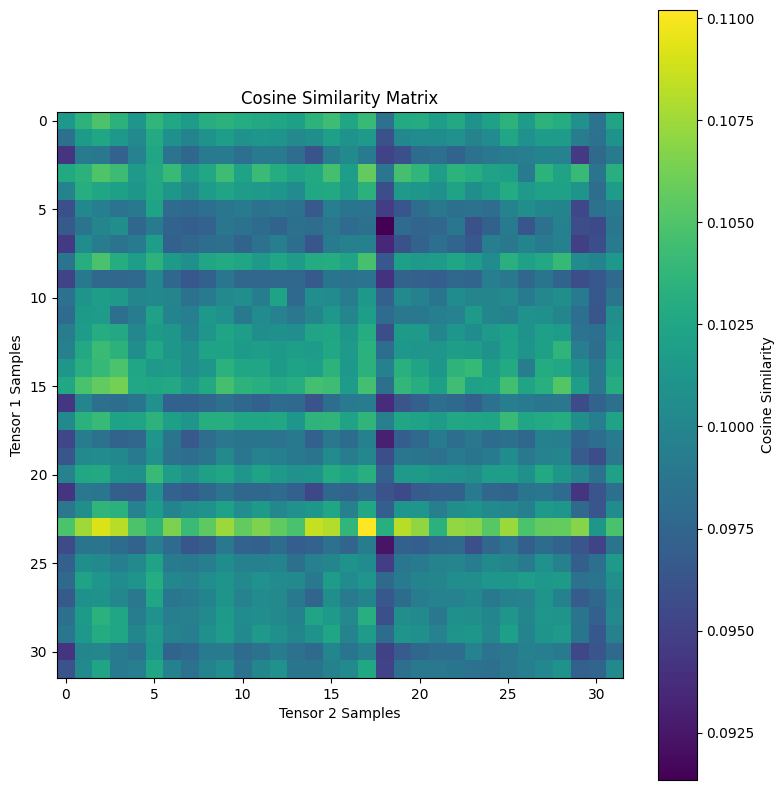

In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt



# Compute the cosine similarity matrix
similarity_matrix = F.cosine_similarity(vision_multi.unsqueeze(1), text_multi.unsqueeze(0), dim=2)



# Plot the similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(similarity_matrix.detach().numpy(), cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Tensor 2 Samples')
plt.ylabel('Tensor 1 Samples')
plt.title('Cosine Similarity Matrix')
plt.tight_layout()
plt.show()


In [ ]:
ids.shape

In [ ]:
output = model(c)